In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
from PIL import Image

import tensorflow as tf
# tf.enable_eager_execution()
# import tensorflow.contrib.eager as tfe
import sys
import os
# from sklearn.utils import shuffle
# from cache import cache
# import pydot
# import graphviz
# from sklearn.model_selection import train_test_split
import time
import pickle
# from tqdm import tqdm
# import copy
# import re
from random import sample
import random
import requests



from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Dropout, Activation, Flatten, Reshape, BatchNormalization

from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.applications.vgg16 import preprocess_input as VGG16_preprocess_input
from tensorflow.python.keras.applications.inception_v3 import InceptionV3
from tensorflow.python.keras.applications.inception_v3 import preprocess_input
from tensorflow.python.keras.applications.inception_v3 import decode_predictions
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.optimizers import RMSprop
#from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
#from tensorflow.python.keras.utils import plot_model
from tensorflow.python.keras.utils import to_categorical

In [2]:
tf.__version__

'1.15.0'

In [3]:
tf.keras.__version__

'2.2.4-tf'

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10158680146066900837
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15712427626381948230
physical_device_desc: "device: XLA_CPU device"
]


# Doanload Data

In [5]:
# os.path.abspath('.')

'/home/c_weiwei_cao/crow'

In [8]:
# annotation_zip = tf.keras.utils.get_file('annotations.zip',
#                                          cache_subdir=os.path.abspath('.')+'/data/',
#                                          origin = 'https://lilablobssc.blob.core.windows.net/caltechcameratraps/labels/caltech_images_20190919.json.zip',
#                                          extract = True)

9478144/9470683 [==============================] - 1s 0us/step


In [12]:
# image_zip = tf.keras.utils.get_file('images.zip',
#                                          cache_subdir=os.path.abspath('.')+'/data/',
#                                          origin = 'https://lilablobssc.blob.core.windows.net/caltechcameratraps/cct_images.tar.gz',
#                                          extract = True)

112540770304/112540764160 [==============================] - 9326s 0us/step


In [13]:
# annotation_zip

'/home/c_weiwei_cao/crow/data/annotations.zip'

In [14]:
# image_zip

'/home/c_weiwei_cao/crow/data/images.zip'

# Prepare Data for Modeling

In [5]:
# get data from json
with open("data/caltech_images_20190919.json", 'r') as f:
    annotations = json.load(f)

annot_df = pd.DataFrame.from_dict(annotations['annotations'])
image_df = pd.DataFrame.from_dict(annotations['images'])

# get animal name map 
category_id = []
category_name = []

for i in annotations['categories']:
    category_id.append(i['id'])
    category_name.append(i['name'])
    
category_dict = dict(zip(category_id, category_name))
annot_df['category_name'] = annot_df['category_id'].map(category_dict)

# drop duplicate annotations
annot_df.sort_values("image_id", inplace = True) 
annot_df_nodup = annot_df.drop_duplicates(subset ="image_id", keep = 'first')

# merge annotation and image data together
image_df.rename(columns={"id": "image_id"}, inplace=True)
image_df.sort_values("image_id", inplace = True) 
image_df_annot = pd.concat([image_df.set_index('image_id'), annot_df_nodup.set_index('image_id')], axis=1, join='inner').reset_index()

image_df_annot.head()

,image_id,seq_num_frames,date_captured,seq_id,height,width,location,rights_holder,file_name,frame_num,id,category_id,category_name
0,5858bf1e-23d2-11e8-a6a3-ec086b02610b,1,2014-07-10 14:20:20,6fc5ac4a-5567-11e8-b3db-dca9047ef277,1494,2048,96,Erin Boydston,test/5858bf1e-23d2-11e8-a6a3-ec086b02610b.jpg,1,52acca15-7d6d-11e7-884d-7845c41c2c67,30,empty
1,5858bf20-23d2-11e8-a6a3-ec086b02610b,1,2014-05-26 13:44:00,6fbb3c73-5567-11e8-b378-dca9047ef277,1494,2048,96,Erin Boydston,test/5858bf20-23d2-11e8-a6a3-ec086b02610b.jpg,1,f77c64a8-7d6e-11e7-884d-7845c41c2c67,30,empty
2,5858bf21-23d2-11e8-a6a3-ec086b02610b,1,2014-09-16 08:16:51,7006f717-5567-11e8-b4c6-dca9047ef277,1494,2048,114,Erin Boydston,test/5858bf21-23d2-11e8-a6a3-ec086b02610b.jpg,1,1aa83e59-7d71-11e7-884d-7845c41c2c67,10,rabbit
3,5858bf22-23d2-11e8-a6a3-ec086b02610b,1,2014-05-27 14:57:44,6fbd60e3-5567-11e8-a122-dca9047ef277,1494,2048,96,Erin Boydston,test/5858bf22-23d2-11e8-a6a3-ec086b02610b.jpg,1,45913ae8-7d6d-11e7-884d-7845c41c2c67,30,empty
4,5858bf23-23d2-11e8-a6a3-ec086b02610b,1,2014-06-06 12:31:06,6fbf5a47-5567-11e8-9655-dca9047ef277,1494,2048,96,Erin Boydston,test/5858bf23-23d2-11e8-a6a3-ec086b02610b.jpg,1,5f7e6e7a-7d6e-11e7-884d-7845c41c2c67,30,empty


# Show Image

In [6]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

def show_image(path, category):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    #path = filenames_train[idx]
    #caption = captions_train[idx]

    # Print the captions for this image.
    print("Category: " + category)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()
    
def show_image_by_category(images=1, category = 'any'):
    path = 'data/cct_images/'
    if category == 'any':
        samples = image_df_annot.sample(n=images)
    else:
        samples = image_df_annot[image_df_annot['category_name']==category].sample(n=images)
    for id, sample in samples.iterrows():
        image_id = sample['image_id']
        filename= 'data/cct_images/'+image_id + '.jpg'
        print(sample['category_name'] + " " + image_id)
        img = load_image(filename)
        plt.imshow(img)
        plt.show()    

deer 597fee58-23d2-11e8-a6a3-ec086b02610b


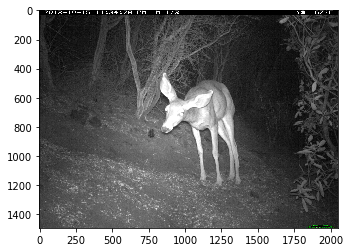

deer 5a26397b-23d2-11e8-a6a3-ec086b02610b


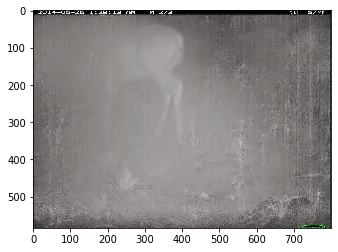

deer 5a0c9b9f-23d2-11e8-a6a3-ec086b02610b


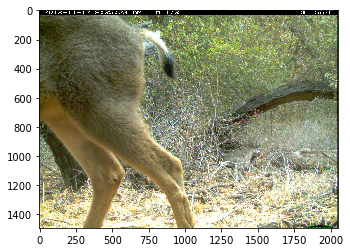

In [10]:
show_image_by_category(3, 'deer')

Category: coyote


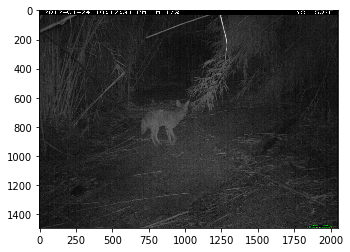

In [21]:
id = 102113
show_image(img_path_vector[id], cat_name_vector[id])

In [7]:
image_df_annot2 = image_df_annot.sort_values(["seq_id", "frame_num"])

In [8]:
image_df_annot2.head(20)

,image_id,seq_num_frames,date_captured,seq_id,height,width,location,rights_holder,file_name,frame_num,id,category_id,category_name
30581,58960811-23d2-11e8-a6a3-ec086b02610b,3,2011-05-31 13:59:06,6efd2387-5567-11e8-8fa6-dca9047ef277,1494,2048,75,Justin Brown,test/58960811-23d2-11e8-a6a3-ec086b02610b.jpg,1,212ad942-7d5b-11e7-884d-7845c41c2c67,30,empty
21503,5883e7c6-23d2-11e8-a6a3-ec086b02610b,3,2011-06-01 03:03:50,6efd254a-5567-11e8-a9e2-dca9047ef277,1494,2048,75,Justin Brown,test/5883e7c6-23d2-11e8-a6a3-ec086b02610b.jpg,1,212ad94f-7d5b-11e7-884d-7845c41c2c67,6,bobcat
103214,5922ebf9-23d2-11e8-a6a3-ec086b02610b,3,2011-06-01 03:03:52,6efd254a-5567-11e8-a9e2-dca9047ef277,1494,2048,75,Justin Brown,test/5922ebf9-23d2-11e8-a6a3-ec086b02610b.jpg,3,212ad959-7d5b-11e7-884d-7845c41c2c67,6,bobcat
82101,58fa5fba-23d2-11e8-a6a3-ec086b02610b,3,2011-06-01 03:03:58,6efd2611-5567-11e8-a6f8-dca9047ef277,1494,2048,75,Justin Brown,test/58fa5fba-23d2-11e8-a6a3-ec086b02610b.jpg,1,212ad955-7d5b-11e7-884d-7845c41c2c67,6,bobcat
123382,5948475f-23d2-11e8-a6a3-ec086b02610b,3,2011-06-01 03:03:59,6efd2611-5567-11e8-a6f8-dca9047ef277,1494,2048,75,Justin Brown,test/5948475f-23d2-11e8-a6a3-ec086b02610b.jpg,2,212ad927-7d5b-11e7-884d-7845c41c2c67,6,bobcat
14533,5874d676-23d2-11e8-a6a3-ec086b02610b,3,2011-06-01 03:04:00,6efd2611-5567-11e8-a6f8-dca9047ef277,1494,2048,75,Justin Brown,test/5874d676-23d2-11e8-a6a3-ec086b02610b.jpg,3,212ad92f-7d5b-11e7-884d-7845c41c2c67,6,bobcat
11595,586fdba6-23d2-11e8-a6a3-ec086b02610b,3,2011-06-02 15:21:09,6efd26a8-5567-11e8-94ff-dca9047ef277,1494,2048,75,Justin Brown,test/586fdba6-23d2-11e8-a6a3-ec086b02610b.jpg,1,212ad952-7d5b-11e7-884d-7845c41c2c67,6,bobcat
39660,58a8a111-23d2-11e8-a6a3-ec086b02610b,3,2011-06-02 15:21:10,6efd26a8-5567-11e8-94ff-dca9047ef277,1494,2048,75,Justin Brown,test/58a8a111-23d2-11e8-a6a3-ec086b02610b.jpg,2,212ad93e-7d5b-11e7-884d-7845c41c2c67,6,bobcat
42873,58af7531-23d2-11e8-a6a3-ec086b02610b,3,2011-06-02 15:21:11,6efd26a8-5567-11e8-94ff-dca9047ef277,1494,2048,75,Justin Brown,test/58af7531-23d2-11e8-a6a3-ec086b02610b.jpg,3,212ad95f-7d5b-11e7-884d-7845c41c2c67,6,bobcat
111794,59328d18-23d2-11e8-a6a3-ec086b02610b,3,2011-06-02 15:53:56,6efd2728-5567-11e8-86fb-dca9047ef277,1494,2048,75,Justin Brown,test/59328d18-23d2-11e8-a6a3-ec086b02610b.jpg,1,212ad92c-7d5b-11e7-884d-7845c41c2c67,6,bobcat


Category: opossum


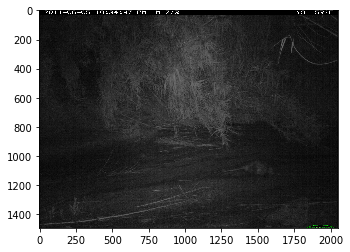

In [64]:
id = 20004
show_image('data/cct_images/' + image_df_annot2.iloc[id]['image_id'] + '.jpg', \
           image_df_annot2.iloc[id]['category_name'])

In [29]:
'data/cct_images/' + image_df_annot2.iloc[3]['image_id'] + '.jpg'

'data/cct_images/58fa5fba-23d2-11e8-a6a3-ec086b02610b.jpg'

# Split Data

In [7]:
loc = image_df_annot['location'].unique()
loc.sort()

In [8]:
loc

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139])

In [9]:
loc2 = image_df_annot.groupby(['location', 'category_name']).image_id.count()

In [10]:
loc2.reset_index().sort_values(by=['location','category_name'])
loc3 = pd.DataFrame(loc2).reset_index()

In [11]:
loc3.head()

,location,category_name,image_id
0,0,badger,6
1,0,bird,10
2,0,bobcat,124
3,0,car,1066
4,0,coyote,304


In [118]:
loc_pivot = loc3.pivot(index='location', columns='category_name', values='image_id')

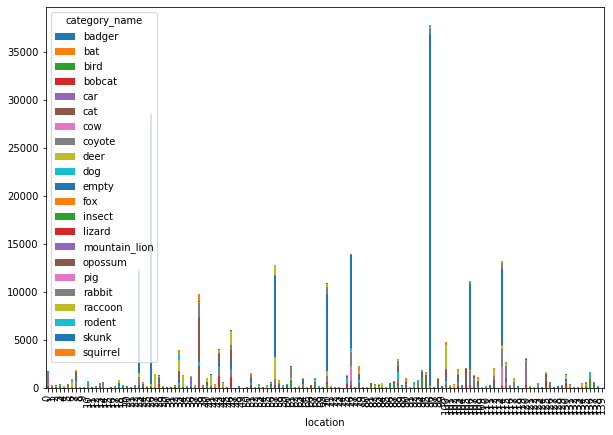

In [90]:
loc_pivot.plot.bar(stacked=True, figsize=(10,7))

In [12]:
url = 'https://lilablobssc.blob.core.windows.net/caltechcameratraps/CaltechCameraTrapsSplits_v0.json'
split = requests.get(url).json()
print(split)

{'info': {'version': '1.0', 'description': 'Train/val splits for Caltech Camera Traps'}, 'splits': {'train': ['10', '102', '103', '106', '107', '108', '108', '108', '109', '11', '110', '111', '112', '113', '115', '115', '115', '116', '117', '118', '119', '12', '120', '120', '120', '121', '122', '123', '124', '126', '127', '128', '129', '13', '131', '132', '133', '134', '135', '137', '138', '14', '15', '16', '17', '18', '2', '20', '21', '22', '23', '24', '25', '26', '29', '3', '31', '33', '33', '33', '35', '36', '38', '38', '38', '39', '4', '41', '43', '43', '43', '44', '47', '48', '49', '5', '50', '51', '51', '51', '52', '53', '55', '56', '57', '58', '59', '6', '61', '61', '61', '62', '64', '65', '66', '70', '71', '73', '75', '79', '80', '81', '82', '83', '86', '87', '88', '88', '88', '89', '90', '90', '90', '92', '93', '94', '96', '97', '98', '99'], 'val': ['0', '1', '100', '101', '104', '105', '114', '125', '130', '136', '139', '19', '27', '28', '30', '32', '34', '37', '40', '42', '4

In [13]:
train_val_loc = list(set(split['splits']['train']))

In [14]:
test_loc = list(set(split['splits']['val']))

In [15]:
#random.seed(0)
SEED=0
val_loc = sample(train_val_loc, 40)

In [16]:
train_loc = [i for i in train_val_loc if i not in val_loc]

In [17]:
print(len(train_loc))
print(len(val_loc))
print(len(test_loc))

60
40
40


In [18]:
train_dist = loc3[loc3['location'].isin(train_loc)].groupby('category_name').image_id.sum().sort_values()
val_dist = loc3[loc3['location'].isin(val_loc)].groupby('category_name').image_id.sum().sort_values()
test_dist = loc3[loc3['location'].isin(test_loc)].groupby('category_name').image_id.sum().sort_values()

train_img = loc3[loc3['location'].isin(train_loc)].image_id.sum()
val_img = loc3[loc3['location'].isin(val_loc)].image_id.sum()
test_img = loc3[loc3['location'].isin(test_loc)].image_id.sum()

In [19]:
print('train: ' + str(train_img))
print('val: ' + str(val_img))
print('test: ' + str(test_img))

train: 143458
val: 37232
test: 62410


In [25]:
train_dist 
#/ train_img

category_name
insect               3
badger              16
mountain_lion       17
cow                 42
lizard             108
skunk              907
fox               1224
squirrel          1620
rodent            1917
dog               2491
raccoon           2946
car               2956
cat               3047
bobcat            3368
bird              4588
deer              5509
rabbit            6391
coyote            7226
opossum           7451
empty            65319
Name: image_id, dtype: int64

In [28]:
val_dist 
#/ val_img

category_name
pig                  2
badger               3
bat                  3
insect               6
mountain_lion       24
lizard              41
cow                 42
car                 90
skunk              400
cat                650
fox                688
squirrel           896
bobcat            1353
rodent            1426
dog               1733
raccoon           2274
opossum           2286
deer              3472
bird              3681
rabbit            3706
coyote            4197
empty            20774
Name: image_id, dtype: int64

In [29]:
test_dist 
#/ test_img

category_name
mountain_lion       15
badger              20
lizard             171
skunk              590
fox                697
rodent            1292
dog               1314
squirrel          1413
car               1586
cat               1703
rabbit            1871
bird              2201
cow               3584
bobcat            3671
deer              3980
raccoon           5593
coyote            6162
opossum           6655
empty            19892
Name: image_id, dtype: int64

### cap the empty class to the highest non-empty class?

In [20]:
classes = ['skunk','fox','rodent','dog','squirrel','cat','rabbit','bird','cow','bobcat','deer','raccoon','coyote','opossum']

In [21]:
classes_dict = dict(zip(classes + ['other'], range(15)))

In [22]:
classes_dict

{'skunk': 0,
 'fox': 1,
 'rodent': 2,
 'dog': 3,
 'squirrel': 4,
 'cat': 5,
 'rabbit': 6,
 'bird': 7,
 'cow': 8,
 'bobcat': 9,
 'deer': 10,
 'raccoon': 11,
 'coyote': 12,
 'opossum': 13,
 'other': 14}

In [23]:
image_df_annot.groupby('category_name').image_id.count().sort_values()

category_name
pig                   2
bat                   3
insect                6
badger               43
mountain_lion       145
lizard              309
skunk              1892
fox                2574
cow                3626
dog                4195
rodent             4272
squirrel           4432
car                4717
cat                5167
bobcat             7952
bird               9521
raccoon           10981
deer              12191
rabbit            12345
coyote            16348
opossum           16634
empty            125745
Name: image_id, dtype: int64

In [24]:
data_keep = image_df_annot[image_df_annot['category_name'].isin(classes)]

In [25]:
# sample 16000 other classes
data_other = image_df_annot[~image_df_annot['category_name'].isin(classes)].sample(n=16000, random_state=1)
data_other['category_name'] = 'other'
data_other['category_id'] = 30

In [26]:
# combine and shuffle
image_df_annot2 = pd.concat([data_keep, data_other]).reset_index().sample(frac=1, random_state=1)

In [27]:
# add class id for training
image_df_annot2['category_id_model'] = image_df_annot2['category_name'].map(classes_dict)

In [28]:
image_df_annot2.groupby('category_name').image_id.count().sort_values()

category_name
skunk        1892
fox          2574
cow          3626
dog          4195
rodent       4272
squirrel     4432
cat          5167
bobcat       7952
bird         9521
raccoon     10981
deer        12191
rabbit      12345
other       16000
coyote      16348
opossum     16634
Name: image_id, dtype: int64

In [29]:
data_train = image_df_annot2[image_df_annot2['location'].isin(train_loc)]
data_val = image_df_annot2[image_df_annot2['location'].isin(val_loc)]
data_test = image_df_annot2[image_df_annot2['location'].isin(test_loc)]

In [30]:
print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

(52559, 15)
(32136, 15)
(43435, 15)


In [31]:
# get image vector
img_vector_train = list('data/cct_images/' + data_train['image_id'] + '.jpg')
img_vector_val = list('data/cct_images/' + data_val['image_id'] + '.jpg')
img_vector_test = list('data/cct_images/' + data_test['image_id'] + '.jpg')

In [32]:
# get category vector
cat_name_vector_train = list(data_train['category_name'])
cat_id_vector_train = list(data_train['category_id_model'])

cat_name_vector_val = list(data_val['category_name'])
cat_id_vector_val = list(data_val['category_id_model'])

cat_name_vector_test = list(data_test['category_name'])
cat_id_vector_test = list(data_test['category_id_model'])

Category: deer


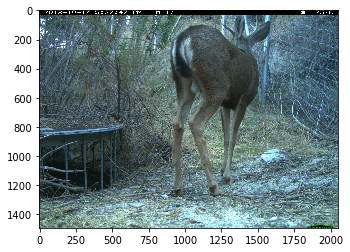

In [125]:
id = 9
show_image(img_vector_train[id], cat_name_vector_train[id])

# Load InceptionV3 Model

In [45]:
model = InceptionV3(weights='imagenet', include_top=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [46]:
print("model structure: ", model.summary())
#print("model weights: ", model.get_weights())

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

### Try using InceptionV3 without re-training to run inference on our data

[[('n02325366', 'wood_rabbit', 0.76865214), ('n02326432', 'hare', 0.0504399), ('n03388043', 'fountain', 0.02028747)]]


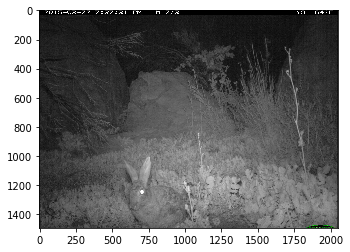

In [95]:
img_path = img_vector_train[12]
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)
 
features = model.predict(x)
print(decode_predictions(features, top = 3))
 
plt.imshow(image.load_img(img_path))
plt.show()

[[('n02423022', 'gazelle', 0.3382604), ('n02422699', 'impala', 0.15817776), ('n02415577', 'bighorn', 0.0778778)]]


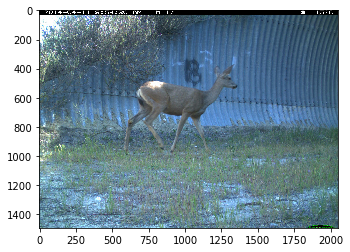

In [96]:
img_path = img_vector_train[13]
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)
 
features = model.predict(x)
print(decode_predictions(features, top = 3))
 
plt.imshow(image.load_img(img_path))
plt.show()

[[('n02423022', 'gazelle', 0.78349143), ('n02422699', 'impala', 0.05957584), ('n02415577', 'bighorn', 0.04937292)]]


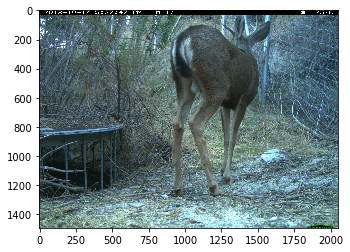

In [47]:
img_path = img_vector_train[9]
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)
 
features = model.predict(x)
print(decode_predictions(features, top = 3))
 
plt.imshow(image.load_img(img_path))
plt.show()

### Transfer learning with InceptionV3 - train last layer - baseline model

In [33]:
# take InceptionV3 without last layer
model_transfer = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [34]:
# freeze all weights
for layer in model_transfer.layers:
    layer.trainable = False

In [35]:
# add new trainable last layer and build model
x = Flatten()(model_transfer.output)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(15, activation="softmax")(x)
model = Model(model_transfer.input, x)

In [36]:
# compile model
model.compile(optimizer = RMSprop(lr=0.0001),loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [38]:
# load and preprocess images
def load_image_for_inception(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = preprocess_input(img)
    img = tf.reshape(img, (1,299,299,3))
    return img

In [39]:
# sample_x_train = tf.data.Dataset.from_tensor_slices(img_vector_train[:1024])
# sample_x_train = sample_x_train.map(load_image_for_inception, 
#                                   num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

In [40]:
# test on 1024 images
sample_x_train = list(map(load_image_for_inception, img_vector_train[:1024]))
sample_x_train = tf.reshape(sample_x_train, (1024,299,299,3))
sample_y_train = to_categorical(cat_id_vector_train[:1024], num_classes=15, dtype='float32')

sample_x_val = list(map(load_image_for_inception, img_vector_val[:32]))
sample_x_val = tf.reshape(sample_x_val, (32,299,299,3))
sample_y_val = to_categorical(cat_id_vector_val[:32], num_classes=15, dtype='float32')

In [ ]:
# train model
%time history = model.fit(sample_x_train, sample_y_train, epochs=32, steps_per_epoch=32,\
                    validation_data=(sample_x_val, sample_y_val), verbose=2)

Train on 32 samples, validate on 32 samples
Epoch 1/32
